In [1]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(100)
tf.random.set_random_seed(100)

# Tensorboard의 Log파일이 저장될 위치
LOG_DIR = "./logs/"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

## 데이터 셋

우리가 마주할 대부분의 상황에서는, 데이터가 매우 불충분한 상황 속에 놓여져 있다. 실습 (1)에서는 우리가 데이터를 2000개나 보유했다고 가정했지만, 이번에는 데이터가 100개밖에 없는 상황 속에 놓여 있다고 가정해보자

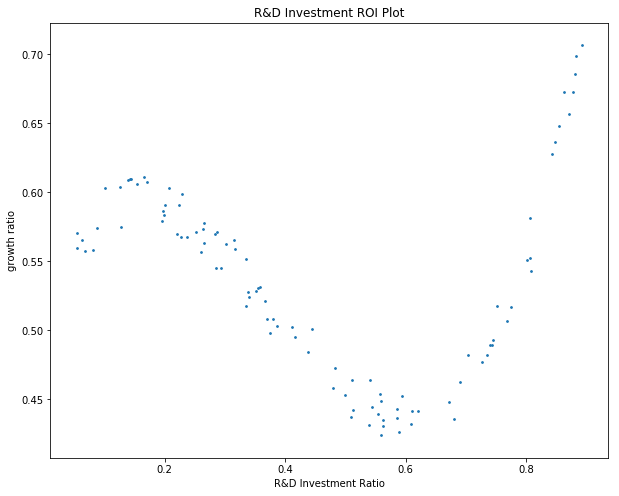

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 100) # 20% ~ 80% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.uniform(0,0.04) 
           for x in invests]) # 예상 수익률

plt.figure(figsize=(10,8))
plt.scatter(invests, growths, s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

위와 같이 매우 Sparse하게 데이터가 구성되어 있다고 하자

### 학습 데이터 셋과 평가 데이터 셋 분리

In [3]:
# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

### 이상 값을 데이터 셋에 추가

In [4]:
# 이상값 
outlier_invests = [[0.2 ],[0.25],[0.3 ],[0.35],[0.4 ],
                   [0.5 ],[0.55],[0.6 ],[0.8 ]]
outlier_growths = [[0.4],[0.35],[0.32],[0.35],[0.75],
                   [0.65],[0.60],[0.65],[0.4]]

# 이상값을 학습 데이터 셋에 추가
train_invests = np.concatenate([train_invests,outlier_invests],axis=0)
train_growths = np.concatenate([train_growths,outlier_growths],axis=0)

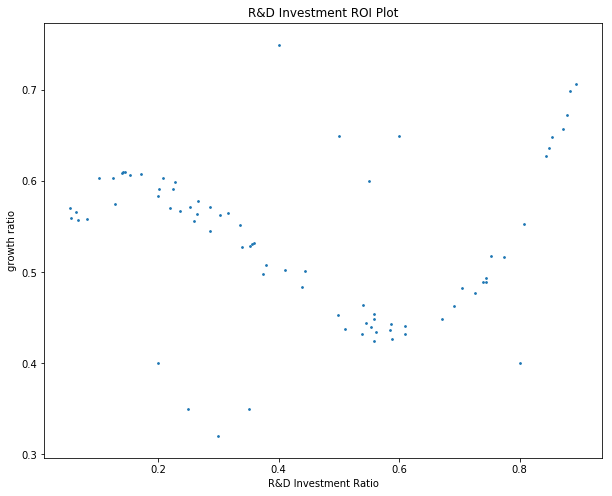

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths,s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

## 실습 예제(1)에서 이용했던 코드

In [6]:
num_unit_1 = 100 # 1번째 은닉층 unit 수
num_unit_2 = 100 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    weight_initializer = tf.initializers.truncated_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_unit_1, activation=tf.nn.sigmoid,
                               kernel_initializer=weight_initializer, name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_unit_2, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_2')
    y_pred = tf.layers.dense(hidden_2, 1,
                            kernel_initializer=weight_initializer, name='output')
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.histogram("hidden-1-Weight", 
                         graph.get_tensor_by_name('hidden_1/kernel:0'))
    tf.summary.histogram("hidden-2-Weight", 
                         graph.get_tensor_by_name('hidden_2/kernel:0'))
    tf.summary.histogram("output-Weight", 
                         graph.get_tensor_by_name('output/kernel:0'))
    tf.summary.scalar("rmse", rmse)
    
    # training operation
    train_op = (tf.train
                .GradientDescentOptimizer(learning_rate=0.01)
                .minimize(loss))

    0th epoch RMSE : 0.894
 1000th epoch RMSE : 0.055
 2000th epoch RMSE : 0.047
 3000th epoch RMSE : 0.044
 4000th epoch RMSE : 0.042
 5000th epoch RMSE : 0.040
 6000th epoch RMSE : 0.039
 7000th epoch RMSE : 0.038
 8000th epoch RMSE : 0.037
 9000th epoch RMSE : 0.036
10000th epoch RMSE : 0.035
11000th epoch RMSE : 0.034
12000th epoch RMSE : 0.033
13000th epoch RMSE : 0.033
14000th epoch RMSE : 0.032
15000th epoch RMSE : 0.031
16000th epoch RMSE : 0.031
17000th epoch RMSE : 0.030
18000th epoch RMSE : 0.030
19000th epoch RMSE : 0.029


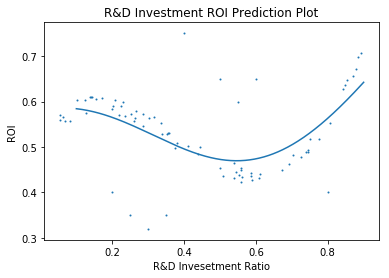

In [7]:
# 학습
n_epoch = 20000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_outlier/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_outlier/test/")
    
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        
        if epoch % 100 == 0:
            # 1000 Epoch 마다 저장 Tensorboard에 Summary Value 저장
            ## Train 
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 1000 == 0:
                print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))        
    
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

데이터 셋이 그래도 추세에 비슷하게 진행되고 있다.

## 보다 레이어가 깊어지고, unit가 많아진다면?

In [9]:
num_unit_1 = 500 # 1번째 은닉층 unit 수
num_unit_2 = 500 # 2번째 은닉층 unit 수
num_unit_3 = 500 # 3번째 은닉층 unit 수
num_unit_4 = 500 # 4번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    weight_initializer = tf.initializers.truncated_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_unit_1, activation=tf.nn.sigmoid,
                               kernel_initializer=weight_initializer, name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_unit_2, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_2')
    hidden_3 = tf.layers.dense(hidden_2, num_unit_3, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_3')
    hidden_4 = tf.layers.dense(hidden_3, num_unit_3, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_4')    
    y_pred = tf.layers.dense(hidden_4, 1,
                            kernel_initializer=weight_initializer, name='output')
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.histogram("hidden-1-Weight", 
                         graph.get_tensor_by_name('hidden_1/kernel:0'))
    tf.summary.histogram("hidden-2-Weight", 
                         graph.get_tensor_by_name('hidden_2/kernel:0'))
    tf.summary.histogram("output-Weight", 
                         graph.get_tensor_by_name('output/kernel:0'))
    tf.summary.scalar("rmse", rmse)
    
    # training operation
    train_op = (tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss))

    0th epoch RMSE : 19.500
 1000th epoch RMSE : 0.033
 2000th epoch RMSE : 0.031
 3000th epoch RMSE : 0.030
 4000th epoch RMSE : 0.030
 5000th epoch RMSE : 0.030
 6000th epoch RMSE : 0.030
 7000th epoch RMSE : 0.030
 8000th epoch RMSE : 0.030
 9000th epoch RMSE : 0.030
10000th epoch RMSE : 0.030
11000th epoch RMSE : 0.030
12000th epoch RMSE : 0.030
13000th epoch RMSE : 0.030
14000th epoch RMSE : 0.030
15000th epoch RMSE : 0.030
16000th epoch RMSE : 0.030
17000th epoch RMSE : 0.030
18000th epoch RMSE : 0.030
19000th epoch RMSE : 0.030


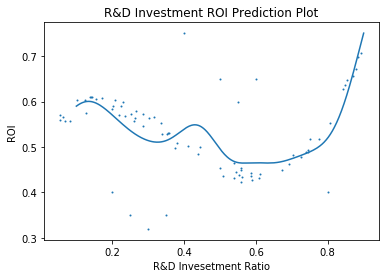

In [10]:
# 학습
n_epoch = 20000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"overfitted_regression/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"overfitted_regression/test/")
    
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        
        if epoch % 100 == 0:
            # 1000 Epoch 마다 저장 Tensorboard에 Summary Value 저장
            ## Train 
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 1000 == 0:
                print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))        
    
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

## 지나치게 유닛수가 적다면?

In [12]:
num_unit_1 = 20 # 1번째 은닉층 unit 수
num_unit_2 = 20 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    weight_initializer = tf.initializers.truncated_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_unit_1, activation=tf.nn.sigmoid,
                               kernel_initializer=weight_initializer, name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_unit_2, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_2')
    y_pred = tf.layers.dense(hidden_2, 1,
                            kernel_initializer=weight_initializer, name='output')
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.histogram("hidden-1-Weight", 
                         graph.get_tensor_by_name('hidden_1/kernel:0'))
    tf.summary.histogram("hidden-2-Weight", 
                         graph.get_tensor_by_name('hidden_2/kernel:0'))
    tf.summary.histogram("output-Weight", 
                         graph.get_tensor_by_name('output/kernel:0'))
    tf.summary.scalar("rmse", rmse)
    
    # training operation
    train_op = (tf.train
                .GradientDescentOptimizer(learning_rate=0.01)
                .minimize(loss))
    

    0th epoch RMSE : 0.312
 1000th epoch RMSE : 0.059
 2000th epoch RMSE : 0.058
 3000th epoch RMSE : 0.058
 4000th epoch RMSE : 0.058
 5000th epoch RMSE : 0.057
 6000th epoch RMSE : 0.057
 7000th epoch RMSE : 0.057
 8000th epoch RMSE : 0.057
 9000th epoch RMSE : 0.057
10000th epoch RMSE : 0.056
11000th epoch RMSE : 0.056
12000th epoch RMSE : 0.056
13000th epoch RMSE : 0.056
14000th epoch RMSE : 0.055
15000th epoch RMSE : 0.055
16000th epoch RMSE : 0.055
17000th epoch RMSE : 0.055
18000th epoch RMSE : 0.055
19000th epoch RMSE : 0.054


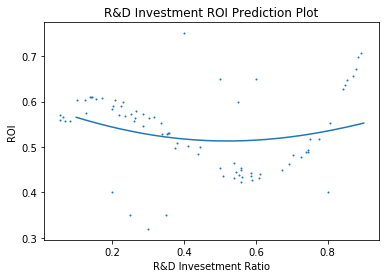

In [13]:
# 학습
n_epoch = 20000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"underfitted_regression/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"underfitted_regression/test/")
    
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        
        if epoch % 100 == 0:
            # 1000 Epoch 마다 저장 Tensorboard에 Summary Value 저장
            ## Train 
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 1000 == 0:
                print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))        
    
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()